In [1]:
import sys
import itertools
from keras.layers import Input, Dense, Reshape, Flatten
from keras import layers, initializers
from keras.models import Model, load_model
import keras.backend as K
import tensorflow as tf
import numpy as np
from seqtools import SequenceTools as ST
from gfp_gp import SequenceGP
from util import AA, AA_IDX
from util import build_vae
from sklearn.model_selection import train_test_split, ShuffleSplit
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize
from keras.utils.generic_utils import get_custom_objects
from util import one_hot_encode_aa, partition_data, get_balaji_predictions, get_samples, get_argmax
from util import convert_idx_array_to_aas, build_pred_vae_model, get_experimental_X_y
from util import get_gfp_X_y_aa
from losses import neg_log_likelihood
import json

import isolearn.io as isoio
import isolearn.keras as isol

import warnings
warnings.filterwarnings("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

def get_z_sample_numpy(z_mean, z_log_var, n_samples=1) :
    
    n = z_mean.shape[0]
    m = z_mean.shape[2]
    
    epsilon = np.random.normal(loc=0., scale=1., size=(n, n_samples, m))
    
    return z_mean + np.exp(0.5 * z_log_var) * epsilon

#Evaluate VAE Likelihood (ELBO) on supplied data
def evaluate_elbo(vae_encoder_model, vae_decoder_model, sequence_one_hots, pwm_start=0, pwm_end=-1, n_samples=1, decoded_pwm_eps=1e-6) :
    _epsilon = 10**-6
    
    if pwm_end == -1 :
        pwm_end = sequence_one_hots.shape[2]
    
    #Get sequence VAE encodings
    z_mean, z_log_var = vae_encoder_model.predict(x=sequence_one_hots, batch_size=32, verbose=False)

    z_mean = np.tile(np.expand_dims(z_mean, axis=1), (1, n_samples, 1))
    z_log_var = np.tile(np.expand_dims(z_log_var, axis=1), (1, n_samples, 1))
    z = get_z_sample_numpy(z_mean, z_log_var, n_samples=n_samples)
    
    #Get re-decoded sequence PWMs
    decoded_pwms = np.zeros((sequence_one_hots.shape[0], n_samples) + sequence_one_hots.shape[1:])

    for sample_ix in range(n_samples) :
        decoded_pwms[:, sample_ix, :, :] = vae_decoder_model.predict(x=z[:, sample_ix, :], batch_size=32, verbose=False)

    decoded_pwms = np.clip(decoded_pwms, decoded_pwm_eps, 1. - decoded_pwm_eps)
    
    sequence_one_hots_expanded = np.tile(np.expand_dims(sequence_one_hots, axis=1), (1, n_samples, 1, 1))
    
    #Calculate reconstruction log prob
    log_p_x_given_z = np.sum(np.sum(sequence_one_hots_expanded[:, :, pwm_start:pwm_end, :] * np.log(np.clip(decoded_pwms[:, :, pwm_start:pwm_end, :], _epsilon, 1. - _epsilon)) / np.log(10.), axis=3), axis=2)

    #Calculate standard normal and importance log probs
    log_p_std_normal = np.sum(norm.logpdf(z, 0., 1.) / np.log(10.), axis=-1)
    log_p_importance = np.sum(norm.logpdf(z, z_mean, np.sqrt(np.exp(z_log_var))) / np.log(10.), axis=-1)

    #Calculate per-sample ELBO
    log_p_vae = log_p_x_given_z + log_p_std_normal - log_p_importance
    log_p_vae_div_n = log_p_vae - np.log(n_samples) / np.log(10.)

    #Calculate mean ELBO across samples (log-sum-exp trick)
    max_log_p_vae = np.max(log_p_vae_div_n, axis=-1)
    
    log_mean_p_vae = max_log_p_vae + np.log(np.sum(10**(log_p_vae_div_n - np.expand_dims(max_log_p_vae, axis=-1)), axis=-1)) / np.log(10.)
    mean_log_p_vae = np.mean(log_mean_p_vae)
    
    return log_mean_p_vae, mean_log_p_vae, log_p_vae


_5k_1
Instructions for updating:
Colocations handled automatically by placer.
mean log(likelihood) = -0.8908
mode log(likelihood) = -0.1512


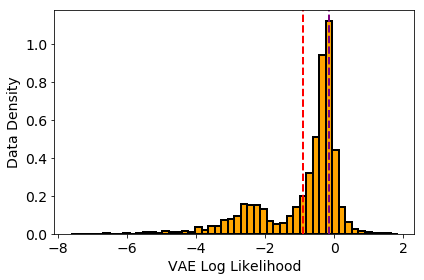

_5k_2
mean log(likelihood) = -0.8669
mode log(likelihood) = -0.1757


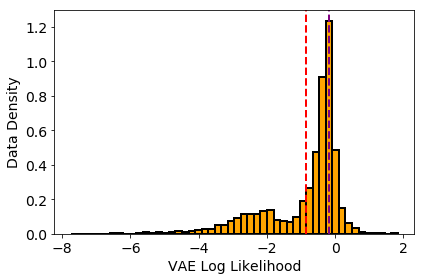

_5k_3
mean log(likelihood) = -0.8558
mode log(likelihood) = -0.1705


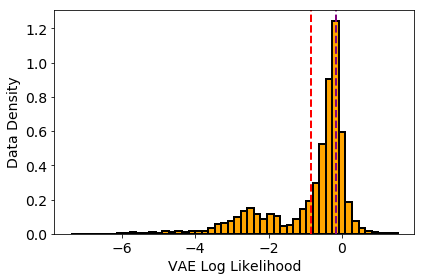

In [3]:
#Evaluate ELBO distribution on GFP dataset, decoder epsilon = 1e-6

n_z_samples = 128

for it in range(3) :

    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    num_models = [1, 5, 20][it]
    RANDOM_STATE = it + 1

    X_train, y_train, gt_train  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)

    L = X_train.shape[1]

    vae_suffix = '_%s_%i' % (train_size_str, RANDOM_STATE)
    
    print(vae_suffix)

    vae_0 = build_vae(latent_dim=20, n_tokens=20, seq_length=L, enc1_units=50)

    vae_0.encoder_.load_weights("models/vae_0_encoder_weights%s.h5" % vae_suffix)
    vae_0.decoder_.load_weights("models/vae_0_decoder_weights%s.h5"% vae_suffix)
    vae_0.vae_.load_weights("models/vae_0_vae_weights%s.h5"% vae_suffix)

    #Compute multi-sample ELBO on test set
    log_mean_p_vae_test, mean_log_p_vae_test, log_p_vae_test = evaluate_elbo(vae_0.encoder_, vae_0.decoder_, X_train, n_samples=n_z_samples)

    #Log Likelihood Plot
    plot_min_val = None
    plot_max_val = None

    f = plt.figure(figsize=(6, 4))

    log_p_vae_test_hist, log_p_vae_test_edges = np.histogram(log_mean_p_vae_test, bins=50, density=True)
    bin_width_test = log_p_vae_test_edges[1] - log_p_vae_test_edges[0]

    mean_log_p_vae_test = np.mean(log_mean_p_vae_test)
    mode_log_p_vae_test = log_p_vae_test_edges[np.argmax(log_p_vae_test_hist)] + bin_width_test / 2.

    print("mean log(likelihood) = " + str(round(mean_log_p_vae_test, 4)))
    print("mode log(likelihood) = " + str(round(mode_log_p_vae_test, 4)))


    plt.bar(log_p_vae_test_edges[1:] - bin_width_test/2., log_p_vae_test_hist, width=bin_width_test, linewidth=2, edgecolor='black', color='orange')

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if plot_min_val is not None and plot_max_val is not None :
        plt.xlim(plot_min_val, plot_max_val)

    plt.xlabel("VAE Log Likelihood", fontsize=14)
    plt.ylabel("Data Density", fontsize=14)

    plt.axvline(x=mean_log_p_vae_test, linewidth=2, color='red', linestyle="--")
    plt.axvline(x=mode_log_p_vae_test, linewidth=2, color='purple', linestyle="--")

    plt.tight_layout()
    plt.show()
